# XRD File reader and plotter

In [66]:
# Importamos librerias necesarias para nuestro programa
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go  # Ensure plotly.graph_objects is imported
from IPython.display import display, Markdown
from scipy.signal import find_peaks
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

---
## Se lee el archivo crudo

En esta parte del código se lee el archivo crudo proveniente del equipo de xrd y se trata para obtener una salida csv


In [67]:
file = open('../SrTiO3.uxd', mode='r')

content = file.read()

partes_importantes = content.split(';')

tabla_contenido = partes_importantes[7]

titles = tabla_contenido[1:15]

tabla_contenido = tabla_contenido.replace(titles, '2THETA, PSD\n')
tabla_contenido = tabla_contenido.replace('       ', ', ')
tabla_contenido = tabla_contenido.replace('      ', ', ')

file.close()

---
## Se convierte el archivo
En esta parte del código el contenido del archivo crudo se convierte en un archivo CSV para posteriormete abrirlo con pandas

In [68]:
output_file = open('data.csv', 'w')

output_file.write(tabla_contenido)

output_file.close()

---

## Creamos la gráfica interactiva para la formula de Debye-Scherrer

En esta parte del código se obtienen los puntos más relevantes de la gráfica y se les da un tratamiento para poder trabajar con ellos.

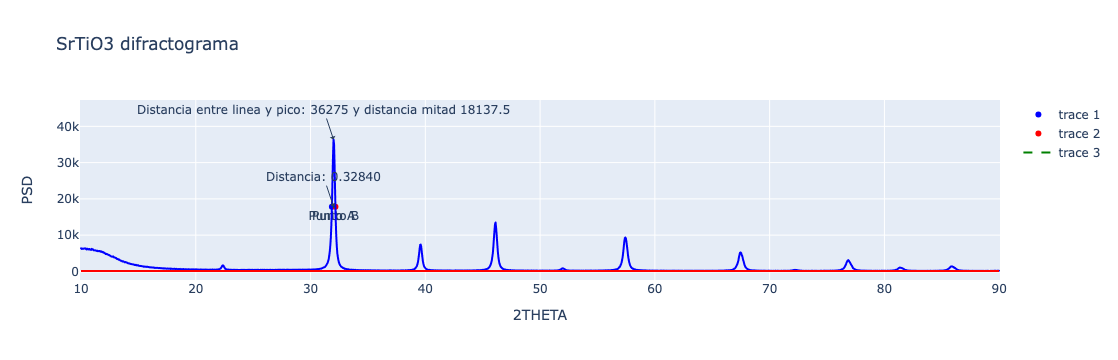

In [84]:
df = pd.read_csv('data.csv')

y_position_value_global = 100
beta_constant_value = 0


fig = px.line(df, x=' 2THETA', y=' PSD', labels={'Name': '2theta', 'Value': 'values'}, title='SrTiO3 difractograma')
fig.update_traces(line=dict(color='blue')) 

# Add a line parallel to x-axis at y_position_value
fig.add_shape(
    type='line',
    x0=df[' 2THETA'].min(),
    y0=y_position_value_global,
    x1=df[' 2THETA'].max(),
    y1=y_position_value_global,
    line=dict(color='red', width=2, dash='solid')
)

#-------------------------------------------------
#Se calcula la altura máxima en de la reflexión más grande:
altura_reflexion_max = max(df[' PSD'].values) - y_position_value_global
# indice reflexión más alta
indice_refle_mas_alta = df[df[' PSD'] == max(df[' PSD'].values)].index[0]
#print(indice_refle_mas_alta)
# Obtenemos la mitad de la distancia con de la reflexión mas grande usando el punto de referencia
given_PSD_value = altura_reflexion_max/2

# Se calcula la diferencia absoluta entre los dos valores dados y todos los datos de la columna PSD.
df['Absolute_Difference'] = abs(df[' PSD'] - given_PSD_value)


# Encuentra la fila con la menor diferencia encontrada
closest_index = df['Absolute_Difference'].idxmin()

closest_2THETA_value = df.loc[closest_index, ' 2THETA']
closest_PSD_value = df.loc[closest_index, ' PSD']

# Encontramos el siguiente valor más cercano
next_upper_values = df[df[' PSD'] > given_PSD_value]
if not next_upper_values.empty:
    next_upper_index = next_upper_values[' PSD'].idxmin()
    next_upper_2THETA = df.loc[next_upper_index, ' 2THETA']
    next_upper_PSD = df.loc[next_upper_index, ' PSD']

#-------------------------------------------------

promedio_de_dos_puntos = ((df[' 2THETA'][next_upper_index] + df[' 2THETA'][next_upper_index + 1])/2) + 0.003

# Agregamos dos puntos con las coordenadas de closes index y el promedio de 2theta en el next_upper_index y next_upper_index + 1
fig.add_trace(go.Scatter(x=[df[' 2THETA'][closest_index]], y=[df[' PSD'][closest_index]], mode='markers+text', text='Punto A', textposition='bottom center', marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=[promedio_de_dos_puntos], y=[df[' PSD'][closest_index]], mode='markers+text', text='Punto B', textposition='bottom center', marker=dict(color='red')))


# Creamos una linea entre esos cos puntos
fig.add_trace(go.Scatter(x=[df[' 2THETA'][closest_index], promedio_de_dos_puntos], y=[df[' PSD'][closest_index], df[' PSD'][closest_index]], mode='lines', line=dict(color='green', dash='dash')))


# Se calcula la distancia con la formula euclidiana
def calculate_fwhm(index):
    half_max = df[' PSD'][index] / 2  # Half of the peak's maximum value
    left_bound = np.where(df[' PSD'][:index] < half_max)[0][-1]  # Left boundary
    right_bound = np.where(df[' PSD'][index:] < half_max)[0][0] + index  # Right boundary
    fwhm = df[' 2THETA'][right_bound] - df[' 2THETA'][left_bound]  # FWHM calculation
    return fwhm

beta_constant_value = calculate_fwhm(indice_refle_mas_alta)  #Se guardan los datos en la variable global
distance_two_points = beta_constant_value
# Se agrega una anotación con esta distancia
fig.add_annotation(
    x=(next_upper_2THETA + closest_2THETA_value)/2,
    y=df[' PSD'][closest_index],
    text=f'Distancia: {distance_two_points:.5f}', # Ponemos la distancia con 3 puntos decimales
    showarrow=True,
    arrowhead=1,
)

fig.add_annotation(
    x=(next_upper_2THETA + closest_2THETA_value)/2,
    y=df[' PSD'][closest_index + 3],
    text=f'Distancia entre linea y pico: {altura_reflexion_max} y distancia mitad {altura_reflexion_max/2}', # Ponemos la distancia con 3 puntos decimales
    showarrow=True,
    arrowhead=1,
)

fig.show()


### Cálculo de tamaño de cristalito a partir de la formula de Debye-Scherrer

&nbsp;

$$D = \frac{K \lambda}{\beta cos(\theta)}$$

Donde: 
- K: Factor de estructura (0.9 para cúbicas [[2](https://www.sciencedirect.com/science/article/pii/S2590182621000175#fo0015)])
- $\lambda$: Longitud de onda CuK$\alpha$ (1.5406 Å)
- $\beta$: Distancia entre __Punto A__ y __Punto B__
- D: Tamaño de cristalito

In [70]:
def calc_tamanio_cristalito_scherrer (beta, theta):
    K = 0.9 # Para cúbicas según la referencia
    LAMBDA = 1.5406 # Longitud de onda Cobre K alfa
    
    #print(theta)
    theta_rads = np.deg2rad(theta)
    angulo = np.cos(theta_rads)
    #print(angulo)
    cristalito_size = (K * LAMBDA)/(beta * angulo)
    #print(f'Tamaño de cristalito calculado: {cristalito_size.values[0]} Å')
    return cristalito_size.values[0] * 0.1 # Se multiplica por 0.1 para convertir A a nm

theta_scherrer = df[df[' PSD'] == max(df[' PSD'].values)][' 2THETA']
#print(theta_scherrer/2)
display(Markdown(f'''
&nbsp;

<div align="center"> Tamaño de cristalito calculado: <b> {calc_tamanio_cristalito_scherrer(np.deg2rad(distance_two_points),(theta_scherrer/2))} nm </b></div>

&nbsp;

'''))


&nbsp;

<div align="center"> Tamaño de cristalito calculado: <b> 25.165847122550165 nm </b></div>

&nbsp;



---

## Creamos la gráfica interactiva para la formula de Williamson-Hall

En esta parte del código se obtienen los puntos más relevantes de la gráfica y se les da un tratamiento para poder trabajar con ellos, sin embargo ahora el tratamiento se hace con base a obtener los datos para calcular el tamaño de cristalito a través de Williamson-Hall

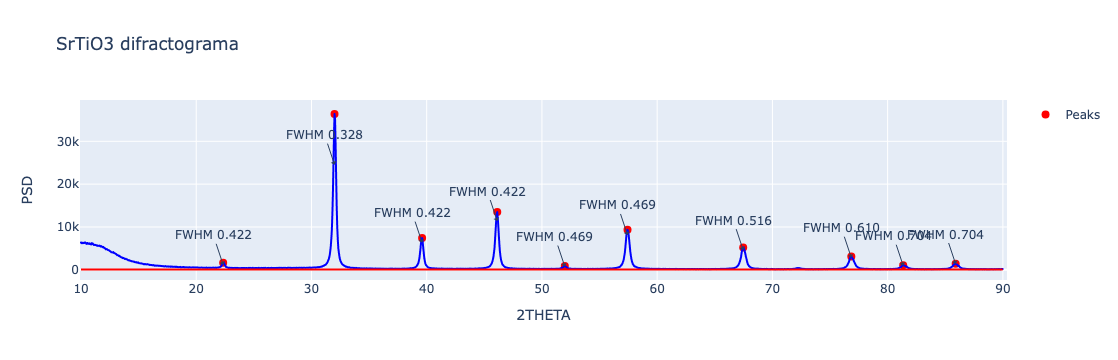

In [94]:
df = pd.read_csv('data.csv')

# Encontramos los picos más altos en la gráfica
peaks, _ = find_peaks(df[' PSD'], prominence=50 , distance= 90)  # Adjust prominence as needed
peaks = np.delete(peaks, 0)
peaks = np.delete(peaks, 1)
peaks = np.delete(peaks, 7)

y_position_value_global = 100
beta_constant_value = 0

lista_picos_index = []

for i in peaks:
    lista_picos_index.append(i)

fig = px.line(df, x=' 2THETA', y=' PSD', labels={'Name': '2theta', 'Value': 'values'}, title='SrTiO3 difractograma')
fig.add_scatter(x=df[' 2THETA'][peaks], y=df[' PSD'][peaks], mode='markers', marker=dict(color='red', size=8), name='Peaks')

fig.update_traces(line=dict(color='blue')) 



# Agregamos una linea horizontal que sirve como punto de referencia
fig.add_shape(
    type='line',
    x0=df[' 2THETA'].min(),
    y0=y_position_value_global,
    x1=df[' 2THETA'].max(),
    y1=y_position_value_global,
    line=dict(color='red', width=2, dash='solid')
)

#-------------------------------------------------
#Se calcula la altura máxima en de la reflexión más grande:
#altura_reflexion_max = max(df[' PSD'].values) - y_position_value_global


def calculate_fwhm(index):
    half_max = df[' PSD'][index] / 2  # Half of the peak's maximum value
    left_bound = np.where(df[' PSD'][:index] < half_max)[0][-1]  # Left boundary
    right_bound = np.where(df[' PSD'][index:] < half_max)[0][0] + index  # Right boundary
    fwhm = df[' 2THETA'][right_bound] - df[' 2THETA'][left_bound]  # FWHM calculation
    return fwhm

def largo_pico(distancia, df_f, peaks):
    
    fig.add_annotation(
        x=df_f[' 2THETA'][peaks],
        y=df_f[' PSD'][peaks - 2],
        text=f'FWHM {distancia:.3f}', # Ponemos la distancia con 3 puntos decimales
        showarrow=True,
        arrowhead=1,
    )

fwhm_values = []
angulos_peaks = []
for peak_index in peaks:
    fwhm = calculate_fwhm(peak_index)
    angulos_peaks.append(df[' 2THETA'][peak_index])
    fwhm_values.append(fwhm)
    #print(f"Peak at index {peak_index}: FWHM = {fwhm}")

for i in range(len(lista_picos_index)):
    largo_pico(fwhm_values[i], df, lista_picos_index[i])

#largo_pico(lista_distancia_entre_picos[1], df,1,1)
#print(lista_picos_index[1])
#print(calculate_fwhm(lista_picos_index[1]))

fig.show()


---

## Se obtienen los datos necesarios para hacer la gráfica $\beta cos\theta$  vs  $sen\theta$ 

In [86]:
lista_de_angulos_2theta =  angulos_peaks
lista_de_angulos_theta = []
for angulo in lista_de_angulos_2theta:
    lista_de_angulos_theta.append(angulo/2)

In [87]:
sen_angulos_plot = []
cos_angulos_plot = []
#print(beta_constant_value)
#beta_constant_value = 3
contador = 0
for angulo in lista_de_angulos_theta:
    #print(fwhm_values[contador])
    #print(np.deg2rad(angulo))
    # Convert the angle from degrees to radians
    deg_angle_sen = np.sin(np.deg2rad(angulo))
    deg_angle_cos =  np.cos(np.deg2rad(angulo))
    
    sen_angulos_plot.append(4 * deg_angle_sen)
    cos_angulos_plot.append(fwhm_values[contador] * deg_angle_cos)
    #print(np.cos(angulo) * beta_constant_value)
    contador += 1

#print(sen_angulos_plot)

## Se grafíca  $\beta cos\theta$  vs  $sen\theta$ 

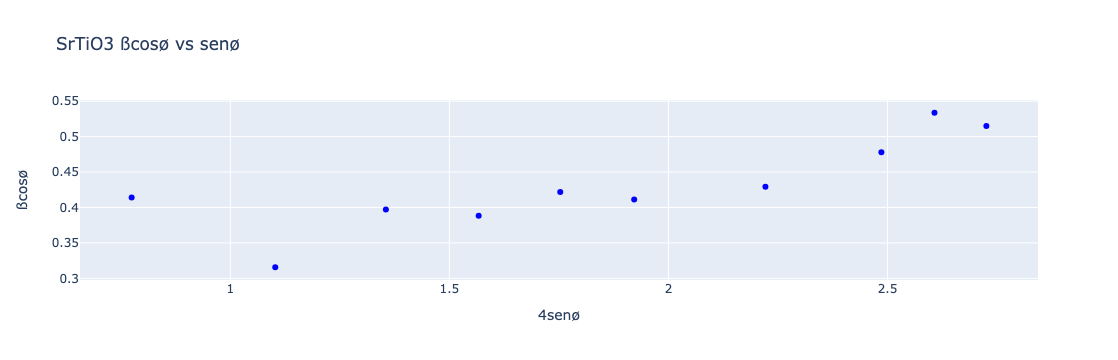

In [88]:
# Add a scatter plot of the list values
# Create a Plotly figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=sen_angulos_plot, y=cos_angulos_plot, mode='markers', marker=dict(color='blue')))

# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='SrTiO3 ßcosø vs senø', xaxis_title='4senø', yaxis_title='ßcosø')

# Show the plot
fig.show()

## Regresión lineal de los datos

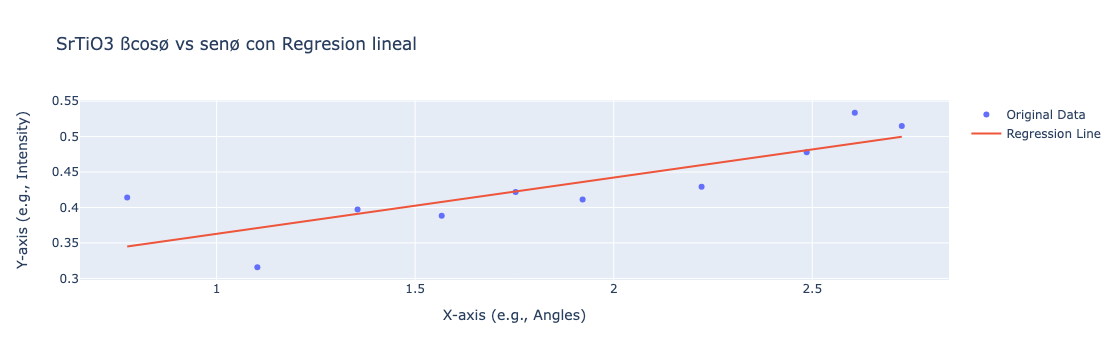


&nbsp;

<div align="center"> Ecuación obtenidad: y = 0.07948605932788505<b> x </b>+ 0.2832693357361943 </b></div>
<div align="center"> $R^2$= 0.6759802329862871 </b></div>

&nbsp;



In [90]:
# Sample XRD data (replace this with your actual data)
x = np.array(sen_angulos_plot) # X-axis data (e.g., angles)
y = np.array(cos_angulos_plot)  # Y-axis data (e.g., intensity)

# Perform linear regression using NumPy
slope, intercept = np.polyfit(x, y, 1)  # 1 for linear regression

# Create the regression line using the slope and intercept
regression_line = slope * x + intercept

# Create a scatter plot with regression line using Plotly
fig = go.Figure()

# Plot the original data points
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))

# Plot the regression line
fig.add_trace(go.Scatter(x=x, y=regression_line, mode='lines', name='Regression Line'))

# Add labels and title
fig.update_layout(
    title='SrTiO3 ßcosø vs senø con Regresion lineal',
    xaxis_title='X-axis (e.g., Angles)',
    yaxis_title='Y-axis (e.g., Intensity)'
)
equation = f'y = {slope}x + {intercept}'

# Calculate R-squared value
r_squared = r2_score(y, regression_line)
# Show the plot
fig.show()

display(Markdown(f'''
&nbsp;

<div align="center"> Ecuación obtenidad: {f'y = {slope}'}<b> x </b>+ {f'{intercept}'} </b></div>
<div align="center"> $R^2$= {r_squared} </b></div>

&nbsp;

'''))


## Calculo del cristalito utilizando la fórmula de Williamson-Hall

Para calcular el cristralito a través de este método tenemos que utilizar la siguiente expresión

$$ \beta_{hkl}cos\theta = \frac{K\lambda}{D} + 4 \epsilon sen\theta$$

si observamos bien podemos darnos cuenta que la fórmula adopta la forma:
$$ y = mx+b $$

Haciendo la regresión lineal de nuestros datos podemos obtener la siguiente expresión

$$  y = 0.11535040977386593 x + 0.24479779320473088 $$

por lo que podemos asumir que:

$$ \frac{K\lambda}{D} = 0.24479779320473088 $$

Asumiendo que:
- K = 0.9
- $\lambda$ = 1.5406 Å

Podemos despejar y obtener el resultado, tal que:

In [91]:
K = 0.9 # Para cúbicas según la referencia
LAMBDA = 1.5406 # Longitud de onda Cobre K alfa

wh_cristalito = (K * LAMBDA)/intercept

display(Markdown(f'''
&nbsp;

<div align="center"> Tamaño de cristalito calculado por Williamson-hall : <b> {wh_cristalito} nm </b></div>

&nbsp;

'''))


&nbsp;

<div align="center"> Tamaño de cristalito calculado por Williamson-hall : <b> 4.894776190287218 nm </b></div>

&nbsp;

